In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Basic info
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget distribution:")
print(df['Churn'].value_counts())

Dataset shape: (7043, 21)

Column names: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...        

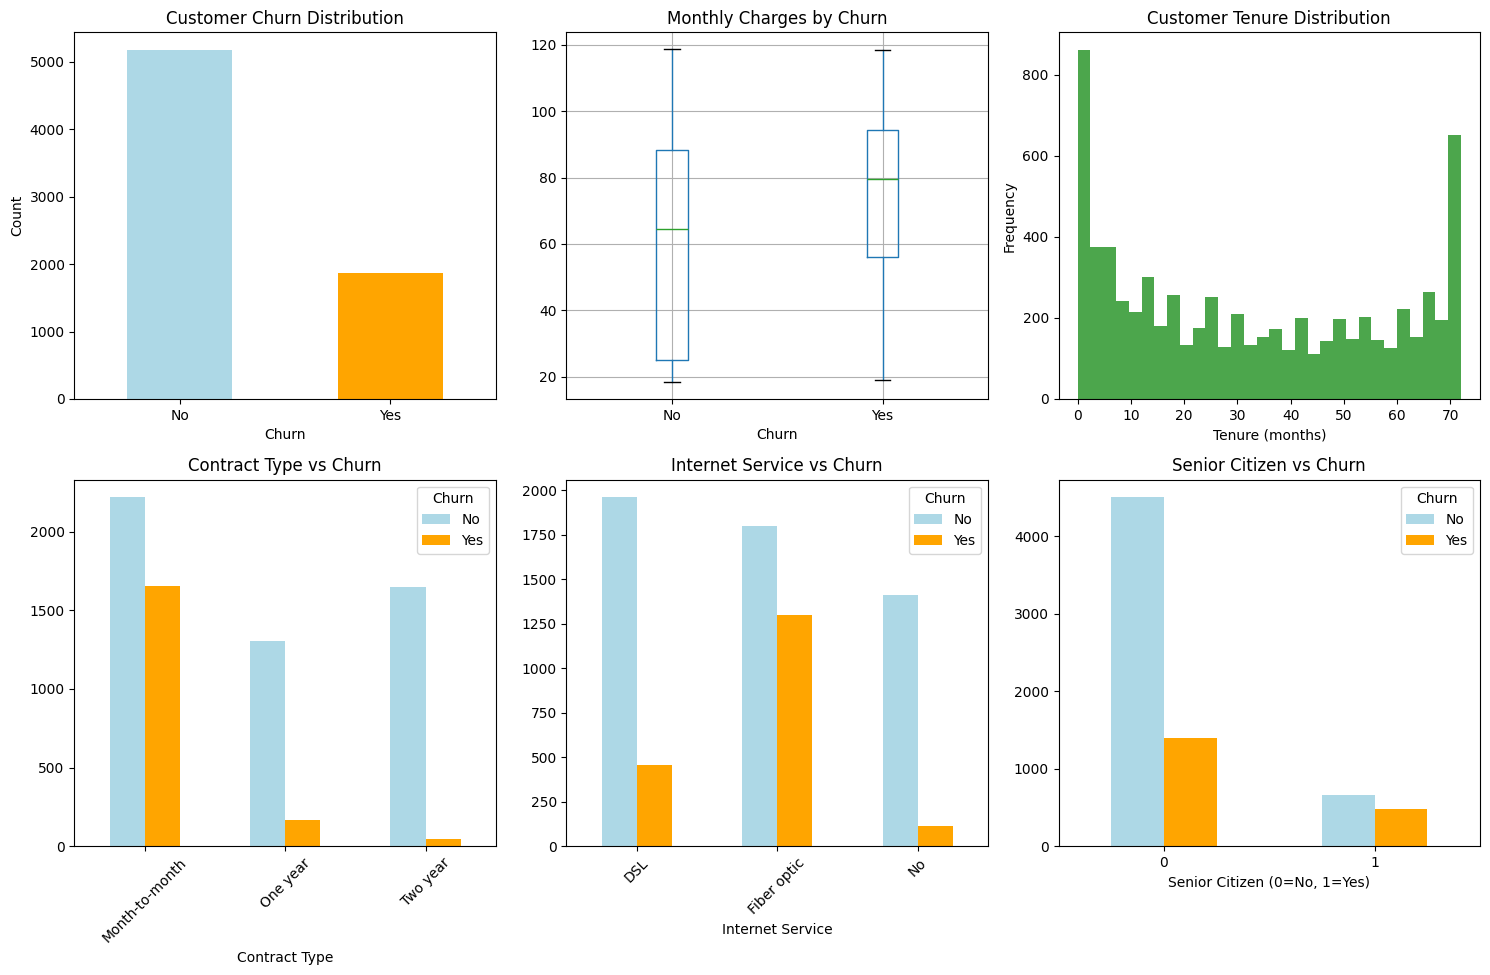

In [3]:
# Data Exploration Charts
plt.figure(figsize=(15, 10))

# 1. Churn distribution
plt.subplot(2, 3, 1)
df['Churn'].value_counts().plot(kind='bar', color=['lightblue', 'orange'])
plt.title('Customer Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 2. Monthly charges by churn
plt.subplot(2, 3, 2)
df.boxplot(column='MonthlyCharges', by='Churn', ax=plt.gca())
plt.title('Monthly Charges by Churn')
plt.suptitle('')

# 3. Tenure distribution
plt.subplot(2, 3, 3)
plt.hist(df['tenure'], bins=30, alpha=0.7, color='green')
plt.title('Customer Tenure Distribution')
plt.xlabel('Tenure (months)')
plt.ylabel('Frequency')

# 4. Contract type vs Churn
plt.subplot(2, 3, 4)
churn_contract = pd.crosstab(df['Contract'], df['Churn'])
churn_contract.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'orange'])
plt.title('Contract Type vs Churn')
plt.xlabel('Contract Type')
plt.xticks(rotation=45)

# 5. Internet Service vs Churn
plt.subplot(2, 3, 5)
churn_internet = pd.crosstab(df['InternetService'], df['Churn'])
churn_internet.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'orange'])
plt.title('Internet Service vs Churn')
plt.xlabel('Internet Service')
plt.xticks(rotation=45)

# 6. Senior Citizen vs Churn
plt.subplot(2, 3, 6)
churn_senior = pd.crosstab(df['SeniorCitizen'], df['Churn'])
churn_senior.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'orange'])
plt.title('Senior Citizen vs Churn')
plt.xlabel('Senior Citizen (0=No, 1=Yes)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [4]:
# Data Preprocessing for Neural Network
# Handle missing values
print("Missing values check:")
print(df.isnull().sum())

# Convert TotalCharges to numeric (it's stored as string)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Drop customerID (not useful for prediction)
df = df.drop('customerID', axis=1)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Don't encode target variable yet

# Label encode all categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target variable
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

print("\nPreprocessed dataset shape:", df.shape)
print("Features after encoding:", df.columns.tolist())
print("\nFirst 5 rows after preprocessing:")
print(df.head())

Missing values check:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Preprocessed dataset shape: (7043, 20)
Features after encoding: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 5 rows after preprocessing:
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0             

<ipython-input-4-c915e4dd8c02>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [5]:
# Prepare data for Neural Network
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)
print("Target distribution in training:", y_train.value_counts())

# Build Neural Network Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nNeural Network Architecture:")
model.summary()

Training set shape: (5634, 19)
Test set shape: (1409, 19)
Target distribution in training: Churn
0    4139
1    1495
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the Neural Network
print("Training Neural Network...")
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Make predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nNeural Network Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Training Neural Network...
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6277 - loss: 0.6268 - val_accuracy: 0.7782 - val_loss: 0.4503
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7760 - loss: 0.4531 - val_accuracy: 0.7853 - val_loss: 0.4450
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7813 - loss: 0.4525 - val_accuracy: 0.7791 - val_loss: 0.4449
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7911 - loss: 0.4187 - val_accuracy: 0.7844 - val_loss: 0.4419
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8002 - loss: 0.4317 - val_accuracy: 0.7808 - val_loss: 0.4428
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8037 - loss: 0.4171 - val_accuracy: 0.7844 - val_loss: 0.4414
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8032 - loss: 0.4081 - val_accuracy: 0.7817 - val_loss: 0.4422
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8096 - lo

=== NEURAL NETWORK EVALUATION ===
Test Accuracy: 0.7878 (78.78%)

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86      1035
       Churn       0.61      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409


Confusion Matrix:
[[907 128]
 [171 203]]


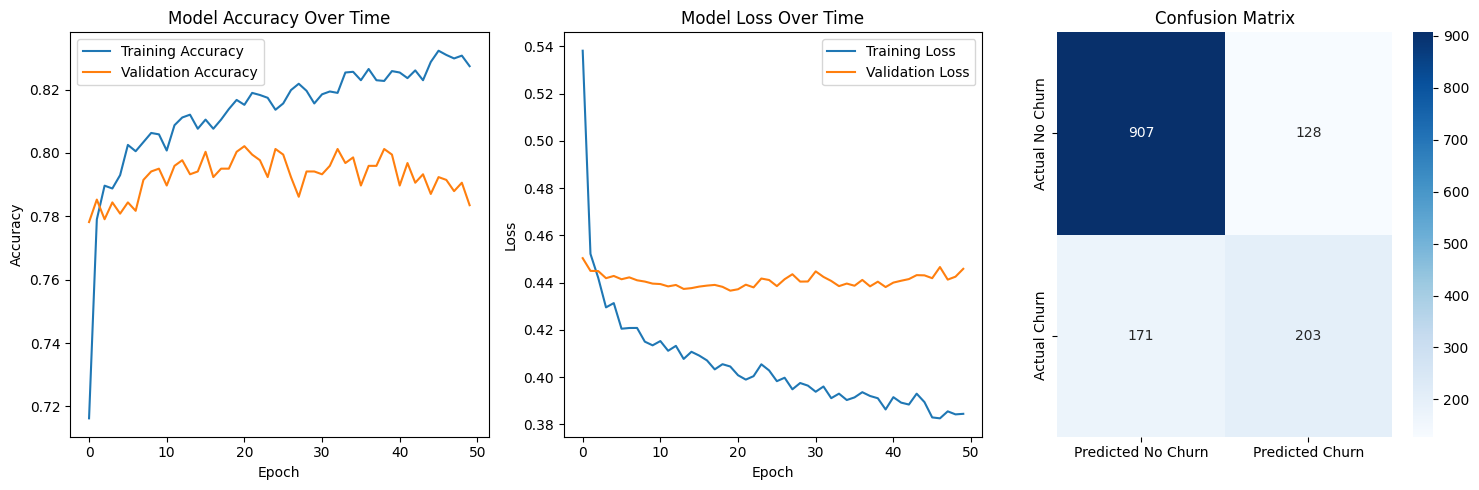


=== HOMEWORK SUMMARY ===
Algorithm: Artificial Neural Network
Dataset: Telco Customer Churn
Total Customers: 7043
Features: 19
Test Accuracy: 0.7878
Model Architecture: 64→32→16→1 neurons


In [7]:
# Final Model Evaluation
print("=== NEURAL NETWORK EVALUATION ===")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualizations
plt.figure(figsize=(15, 5))

# 1. Training History
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss History
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 3. Confusion Matrix Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

print("\n=== HOMEWORK SUMMARY ===")
print("Algorithm: Artificial Neural Network")
print("Dataset: Telco Customer Churn")
print(f"Total Customers: {len(df)}")
print(f"Features: {X.shape[1]}")
print(f"Test Accuracy: {accuracy:.4f}")
print("Model Architecture: 64→32→16→1 neurons")